In [7]:
import numpy as np
from PIL import Image, ImageDraw, ImageChops
from skimage import img_as_float
from skimage.metrics import structural_similarity as ssim

In [8]:
# Load image shape from the file
img = Image.open('input/Cube.png')
# Convert to grayscale
img = img.convert('L')

# Define the brush stroke parameters
brush_size = 100
brush_intensity = 1.0

# Define the number of candidate stroke sets to generate
num_candidates = 10

# Define the maximum number of brush strokes to use
max_strokes = 50

min_strokes = 3

# Define the fitness threshold to stop the optimization
fitness_threshold = 0.7

# Define the search space for the brush stroke positions
search_space = (0, 0, img.width, img.height)

0.1803042619825708


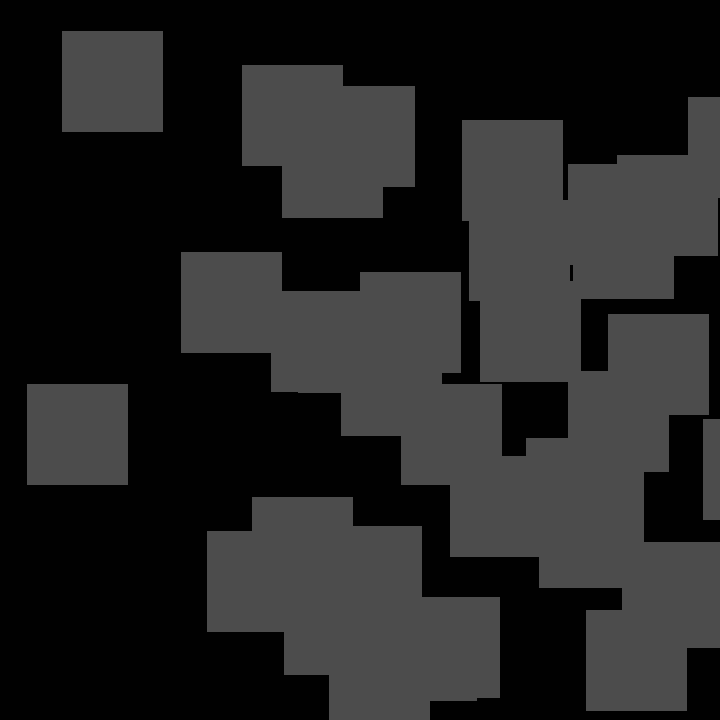

In [9]:
# Initialize the canvas for drawing the brush strokes
canvas = Image.new('L', img.size, 1)

# Define a function to generate a random brush stroke
def generate_stroke():
    x = np.random.randint(search_space[0], search_space[2])
    y = np.random.randint(search_space[1], search_space[3])
    return (x, y, x + brush_size, y + brush_size)

def similarity(img1, img2):
    diff = ImageChops.difference(img1, img2)
    diff = img_as_float(diff)
    return np.mean(diff)

# Generate a set of candidate brush stroke sets
candidates = []
for i in range(num_candidates):
    strokes = [generate_stroke() for j in range(np.random.randint(min_strokes, max_strokes))]
    image = Image.new('L', img.size, 1)
    draw = ImageDraw.Draw(image)
    for stroke in strokes:
        draw.rectangle(stroke, fill="red")
    candidates.append((image, strokes))

# Evaluate the fitness of each candidate stroke set
fitness_scores = []
for candidate in candidates:
    # Calculate the structural similarity between the image and the candidate
    # score = ssim(img_as_float(img), img_as_float(candidate[0]), data_range=1.0)
    score = similarity(img, candidate[0])
    fitness_scores.append(score)

# Show best candidate
best_candidate = candidates[np.argmax(fitness_scores)]
print(np.max(fitness_scores))
best_candidate[0]

In [14]:
# Iterate until the fitness threshold is reached or the maximum number of iterations is reached
best_candidate = None
best_fitness = 0
iteration = 0
while iteration < 100 and best_fitness < fitness_threshold:
    # Generate a new set of candidate brush stroke sets by modifying the existing ones
    new_candidates = []
    for candidate in candidates:
        # Generate a new candidate by modifying the existing one
        new_candidate = candidate[1].copy()
        # Randomly select some brush stroke to modify
        num_strokes_to_modify = np.random.randint(1, len(new_candidate[1]))
        strokes_to_modify = np.random.choice(len(new_candidate), num_strokes_to_modify, replace=False)
        # Modify the selected brush strokes
        for stroke in strokes_to_modify:
            new_candidate[stroke] = generate_stroke()
        # Draw the new candidate brush strokes
        image = Image.new('L', img.size, 1)
        draw = ImageDraw.Draw(image)
        for stroke in new_candidate:
            draw.rectangle(stroke, fill="red")
        new_candidates.append((image, new_candidate))
        # Add the existing candidate to the new set of candidates
        new_candidates.append(candidate)
        

    # Evaluate the fitness of the new candidate stroke sets
    new_fitness_scores = []
    for candidate in new_candidates:
        # score = ssim(np.array(image), np.array(candidate[0]))
        score = similarity(img, candidate[0])
        new_fitness_scores.append(score)
    
    # Select the best candidate stroke set
    best_index = np.argmax(new_fitness_scores)
    if new_fitness_scores[best_index] > best_fitness:
        best_candidate = new_candidates[best_index]
        best_fitness = new_fitness_scores[best_index]

    del candidates    
    candidates = new_candidates
    fitness_scores = new_fitness_scores
    # Combine the fitness scores of the existing candidates and the new candidates
    temp = zip(fitness_scores, candidates)
    # Sort the candidates by fitness score
    temp = sorted(temp, key=lambda x: x[0], reverse=False)
    fitness_scores, candidates = zip(*temp)

    # Remove half of the worst candidates
    candidates = candidates[:len(candidates) // 2]

    # Print the best fitness score and the number of brush strokes used
    print('Iteration: ', iteration, 'fitness score: ', best_fitness, ', number of brush strokes: ', len(best_candidate[1]))
    iteration += 1
    if iteration % 10 == 0:
        best_candidate[0].save('output/iteration_' + str(iteration) + '.png')

img.save('output/target.png')

Iteration:  0 fitness score:  0.07194653231663037 , number of brush strokes:  35
Iteration:  1 fitness score:  0.07335130718954247 , number of brush strokes:  35
Iteration:  2 fitness score:  0.07362307098765432 , number of brush strokes:  35
Iteration:  3 fitness score:  0.07921607207697894 , number of brush strokes:  35
Iteration:  4 fitness score:  0.07921607207697894 , number of brush strokes:  35
Iteration:  5 fitness score:  0.07921607207697894 , number of brush strokes:  35
Iteration:  6 fitness score:  0.07921607207697894 , number of brush strokes:  35
Iteration:  7 fitness score:  0.07921607207697894 , number of brush strokes:  35
Iteration:  8 fitness score:  0.07921607207697894 , number of brush strokes:  35
Iteration:  9 fitness score:  0.07921607207697894 , number of brush strokes:  35
Iteration:  10 fitness score:  0.07921607207697894 , number of brush strokes:  35
Iteration:  11 fitness score:  0.07921607207697894 , number of brush strokes:  35
Iteration:  12 fitness sco

In [1]:
import cv2
import numpy as np

# Read the image in grayscale
img = cv2.imread('input/Cube.png', 0)

# Apply thresholding to the image
thresh_value = 127
_, thresh = cv2.threshold(img, thresh_value, 255, cv2.THRESH_BINARY)

# Find contours in the binary image
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Iterate through the contours and find the bounding rotated rectangle
largest_area = 0
best_rect = None
for cnt in contours:
    # Find the area of the contour
    area = cv2.contourArea(cnt)
    # Find the rotated rectangle that encloses the contour
    rect = cv2.minAreaRect(cnt)
    # Calculate the ratio of the contour area to the area of the bounding rectangle
    rect_area = rect[1][0] * rect[1][1]
    ratio = area / rect_area
    # Choose the rotated rectangle with the largest area that also has a high ratio
    if area > largest_area and ratio > 0.5:
        largest_area = area
        best_rect = rect

# Draw the bounding rectangle on the original image
img_with_rect = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
box = cv2.boxPoints(best_rect)
box = np.int0(box)
cv2.drawContours(img_with_rect, [box], 0, (0, 0, 255), 2)

# Show the original image and the image with the bounding rectangle
cv2.imshow('Original Image', img)
cv2.imshow('Image with Bounding Rectangle', img_with_rect)
cv2.waitKey(5000)
cv2.destroyAllWindows()


NameError: name 'np' is not defined